In [27]:
import scipy.integrate as integrate
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import matplotlib
from __future__ import division
import multiprocessing
from scipy import integrate,optimize,interpolate
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, interp1d
from scipy.integrate import tplquad,dblquad,quad
from scipy.special import sph_harm
from numpy import *
%matplotlib inline

In [28]:
class Parameter:
    def __init__(self):
        self.c                 = 2.99792458e8 # m/s
        self.G                 = 6.6726e-11 # m^3/(kg*s^2)
        self.MpcInM            = 3.0856e+22 # meter in Mpc
        self.H0                = 67.8 #km/s/Mpc
        self.H_0_SI            = self.H0*1000/self.MpcInM
        self.p_c               = 3*(self.H_0_SI*self.c)**2/(8*np.pi*self.G)
        self.pc2m              = 3.0856e+16 # meter in pc
        self.yr2s              = 3.1536e+7 # second in one year
        self.universe_age_yr   = 1.3813e+10 # year
        self.universe_age      = 1.3813e+10*self.yr2s # age of the universe
        self.solar_mass        = 1.989e+30 # solar mass in kg
        self.p_c_SI            = 8.63286552e-27 #kg/m^3
        self.MpcIns            = (self.pc2m*1e6)/self.c
        self.AU                = 1.4959e11 #m

In [29]:
para          = Parameter()

In [30]:
L_TQ      = np.sqrt(3)*1e8 # m
L_LISA    = 2.5e9 # m
fstar_TQ  = para.c/(2*np.pi*L_TQ)
fstar_LISA = para.c/(2*np.pi*L_LISA)

In [31]:
def f(x):
    return np.exp(-x**2)/(2*np.pi)**0.5

In [32]:
def f1(x):
    return f(x-2.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


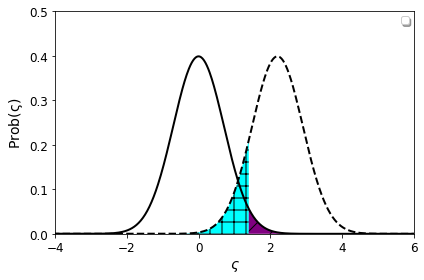

In [33]:
plt.plot(np.linspace(-10,10,1000),f(np.linspace(-10,10,1000)),c='black',linewidth=2)
plt.plot(np.linspace(-10,10,1000),f1(np.linspace(-10,10,1000)),'--',c='black',linewidth=2)
#plt.axvline(x=1.4,ls='-',c="green")
plt.fill_between(np.linspace(-10,1.4,1000),f1(np.linspace(-10,1.4,1000)),0,hatch='|-',facecolor='cyan')
plt.fill_between(np.linspace(1.4,10,1000),f(np.linspace(1.4,10,1000)),0,hatch='/',facecolor='purple')
plt.xlim((-4,6))
plt.ylim((0,0.5))
plt.xlabel(r'$\varsigma$',fontsize=14,)
plt.ylabel(r'$\rm{Prob}(\varsigma)$',fontsize=14,)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12,)
plt.legend(loc='upper right',shadow='true',ncol=1,fontsize=10)
plt.tight_layout()
plt.savefig('Prob_z.png',dpi=500)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


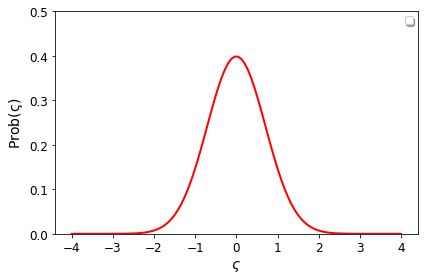

In [34]:
plt.plot(np.linspace(-4,4,100),f(np.linspace(-4,4,100)),c='red',linewidth=2)
plt.ylim((0,0.5))
plt.xlabel(r'$\varsigma$',fontsize=14,)
plt.ylabel(r'$\rm{Prob}(\varsigma)$',fontsize=14,)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12,)
plt.legend(loc='upper right',shadow='true',ncol=1,fontsize=10)
plt.tight_layout()
plt.savefig('Prob_z.png',dpi=500)

# Coordinate

$\vec{k}=(-\sin\theta\cos\phi,-\sin\theta\sin\phi,-\cos\theta)$

$\vec{m}=(\sin\phi,-\cos\phi,0)$

$\vec{l}=(\cos\theta\cos\phi,\cos\theta\sin\phi,-\sin\theta)$

In [35]:
def vec_k(theta,phi):
    temp = np.zeros(3)
    temp[0] = -np.sin(theta)*np.cos(phi)
    temp[1] = -np.sin(theta)*np.sin(phi)
    temp[2] = -np.cos(theta)
    return temp
def vec_m(theta,phi):
    temp = np.zeros(3)
    temp[0] = np.sin(phi)
    temp[1] = -np.cos(phi)
    temp[2] = 0
    return temp
def vec_l(theta,phi):
    temp = np.zeros(3)
    temp[0] = np.cos(theta)*np.cos(phi)
    temp[1] = np.cos(theta)*np.sin(phi)
    temp[2] = -np.sin(theta)
    return temp

$e_{ab}^{+}=\vec{l_{a}}\vec{l_{b}}-\vec{m_{a}}\vec{m_{b}}$

$e_{ab}^{\times}=\vec{l_{a}}\vec{m_{b}}+\vec{m_{a}}\vec{l_{b}}$

In [36]:
def e_plus(theta,phi):
    temp = np.zeros((3,3))
    temp[0][0] = -np.sin(phi)**2+np.cos(theta)**2*np.cos(phi)**2
    temp[0][1] = temp[1][0] = 1/2*np.sin(2*phi)*(1+np.cos(theta)**2)
    temp[0][2] = temp[2][0] = -1/2*np.sin(2*theta)*np.cos(phi)
    temp[1][1] = -np.cos(phi)**2+np.cos(theta)**2*np.sin(phi)**2
    temp[1][2] = temp[2][1]= -1/2*np.sin(2*theta)*np.sin(phi)
    temp[2][2] = np.sin(theta)**2
    return temp
print (e_plus(1,100))

[[-0.03933136 -0.564118   -0.39205217]
 [-0.564118   -0.66874206  0.23021849]
 [-0.39205217  0.23021849  0.70807342]]


In [37]:
def e_cross(theta,phi):
    temp = np.zeros((3,3))
    temp[0][0] = np.sin(2*phi)*np.cos(theta)
    temp[0][1] = temp[1][0] = -np.cos(2*phi)*np.cos(theta)
    temp[0][2] = temp[2][0] = -np.sin(phi)*np.sin(theta)
    temp[1][1] = -np.sin(2*phi)*np.cos(theta)
    temp[1][2] = temp[2][1] = np.cos(phi)*np.sin(theta)
    return temp
print (e_cross(1,100))

[[-0.47184454 -0.26322862  0.42609199]
 [-0.26322862  0.47184454  0.72561631]
 [ 0.42609199  0.72561631  0.        ]]


# Spacecraft

TianQin

# arxiv:1803.03368

Spacecraft position coordinate

$X(t)=R\cos(\alpha(t)-\beta)+\frac{1}{2}eR\big(\cos2(\alpha(t)-\beta)-3\big)-\frac{3}{2}e^{2}R\cos(\alpha(t)-\beta)\sin^{2}(\alpha(t)-\beta)$

$Y(t)=R\sin(\alpha(t)-\beta)+\frac{1}{2}eR\sin2(\alpha(t)-\beta)+\frac{1}{4}e^{2}R\sin(\alpha-\beta)\big(3\cos2(\alpha-\beta)-1\big)$

$Z(t)=0$

$e=0.0167$

$R=1\,AU$

$\alpha(t)=2\pi f_{m}t+\kappa_{0_{TQ}}$

$\kappa_{0_{TQ}}=0$

$f_{m}=1/yr$

the longitude of the perihelion

$\beta=102.9^{\circ}$

In [38]:
def X_tq(t):
    R_TQ    = para.AU
    e       = 0.0167
    alpha   = 2*np.pi*t/para.yr2s
    beta    = np.pi*(102.9/180)
    return R_TQ*np.cos(alpha-beta)+1/2*e*R_TQ*(np.cos(2*(alpha-beta))-3)-3/2*e**2*R_TQ*np.cos(alpha-beta)*(np.sin(alpha-beta))**2

def Y_tq(t):
    R_TQ    = para.AU
    e       = 0.0167
    alpha   = 2*np.pi*t/para.yr2s
    beta    = np.pi*(102.9/180)
    return R_TQ*np.sin(alpha-beta)+1/2*e*R_TQ*(np.sin(2*(alpha-beta)))+1/4*e**2*R_TQ*np.sin(alpha-beta)*(3*np.cos(2*(alpha-beta))-1)

def Z_tq(t):
    return 0

$\alpha_{n}=2\pi f_{sc}t+\kappa_{n}$

$R_{1}=1\times10^{5}\,km$

$\theta_{s}=-4.7^{\circ}$

$\phi_{s}=120.5^{\circ}$

$f_{sc}=1/(3.64\,day)$

$x_{n}^{'}(t)=R_{1}\big(\cos\phi_{s}\sin\theta_{s}\sin(\alpha_{n}-\beta^{'})+\cos(\alpha_{n}-\beta^{'})\sin\phi_{s}\big)+R_{1}e_{1}\bigg[\frac{1}{2}\big(\cos(\alpha_{n}-\beta^{'})-3\big)\sin\phi_{s}+\cos(\alpha_{n}-\beta^{'})\cos\phi_{s}\sin\theta_{s}\sin(\alpha_{n}-\beta^{'})\bigg]\\
+\frac{e_{1}^{2}}{4}R_{1}\sin(\alpha_{n}-\beta^{'})\bigg[\big(3\cos2(\alpha_{n}-\beta^{'})-1\big)\cos\phi_{s}\sin\theta_{s}-6\cos(\alpha_{n}-\beta^{'})\sin(\alpha_{n}-\beta^{'})\sin\phi_{s}\bigg]$

In [39]:
def x_tq(t):
    R1      = 1e8 #m
    phi_s   = np.pi*(120.5/180)
    theta_s = np.pi*(-4.7/180)
    f_sc    = 1/(3.64*3600*24)
    k_n     = np.zeros(3)
    a_n     = np.zeros(3)
    k_n[0]  = 2*np.pi/3*0
    k_n[1]  = 2*np.pi/3*1
    k_n[2]  = 2*np.pi/3*2
    a_n0    = np.pi/5
    a_n     = 2*np.pi*f_sc*t+k_n+np.pi/5
    beta1   = 0
    temp    = np.zeros(3)
    temp    = R1*(np.cos(phi_s)*np.sin(theta_s)*np.sin(a_n-beta1)+np.cos(a_n-beta1)*np.sin(phi_s))
    return temp

$y_{n}^{'}(t)=R_{1}\big(\sin\phi_{s}\sin\theta_{s}\sin(\alpha_{n}-\beta^{'})-\cos(\alpha_{n}-\beta^{'})\cos\phi_{s}\big)+R_{1}e_{1}\bigg[-\frac{1}{2}\big(\cos(\alpha_{n}-\beta^{'})-3\big)\cos\phi_{s}+\cos(\alpha_{n}-\beta^{'})\sin\phi_{s}\sin\theta_{s}\sin(\alpha_{n}-\beta^{'})\bigg]\\
+\frac{e_{1}^{2}}{4}R_{1}\sin(\alpha_{n}-\beta^{'})\bigg[\big(3\cos2(\alpha_{n}-\beta^{'})-1\big)\sin\phi_{s}\sin\theta_{s}+6\cos(\alpha_{n}-\beta^{'})\sin(\alpha_{n}-\beta^{'})\cos\phi_{s}\bigg]$

In [40]:
def y_tq(t):
    R1      = 1e8 #m
    phi_s   = np.pi*(120.5/180)
    theta_s = np.pi*(-4.7/180)
    f_sc    = 1/(3.64*3600*24)
    k_n     = np.zeros(3)
    a_n     = np.zeros(3)
    k_n[0]  = 2*np.pi/3*0
    k_n[1]  = 2*np.pi/3*1
    k_n[2]  = 2*np.pi/3*2
    a_n0    = np.pi/5
    a_n     = 2*np.pi*f_sc*t+k_n+np.pi/5
    beta1   = 0
    temp    = np.zeros(3)
    temp    = R1*(np.sin(phi_s)*np.sin(theta_s)*np.sin(a_n-beta1)-np.cos(a_n-beta1)*np.cos(phi_s))
    return temp

$z_{n}^{'}(t)=-R_{1}\sin(\alpha_{n}-\beta^{'})\cos\theta_{s}-R_{1}e_{1}\cos(\alpha_{n}-\beta^{'})\sin(\alpha_{n}-\beta^{'})\cos\theta_{s}-\frac{1}{4}e_{1}^{2}R_{1}\big(3\cos2(\alpha_{n}-\beta^{'})-1\big)\sin(\alpha_{n}-\beta^{'})\cos\theta_{s}$

In [41]:
def z_tq(t):
    R1      = 1e8 #m
    phi_s   = np.pi*(120.5/180)
    theta_s = np.pi*(-4.7/180)
    f_sc    = 1/(3.64*3600*24)
    k_n     = np.zeros(3)
    a_n     = np.zeros(3)
    k_n[0]  = 2*np.pi/3*0
    k_n[1]  = 2*np.pi/3*1
    k_n[2]  = 2*np.pi/3*2
    a_n0    = np.pi/5
    a_n     = 2*np.pi*f_sc*t+k_n+np.pi/5
    beta1   = 0
    temp    = np.zeros(3)
    temp    = -R1*np.sin(a_n-beta1)*np.cos(theta_s)
    return temp

In [42]:
def X_tq_eli(t):
    return X_tq(t)+x_tq(t)
def Y_tq_eli(t):
    return Y_tq(t)+y_tq(t)
def Z_tq_eli(t):
    return Z_tq(t)+z_tq(t)

LISA

# Cornish, N. J.,& Rubbo, L. J. 2003, Phys. Rev. D, 67, 022001
# arxiv:gr-qc/0504071
Spacecraft position coordinate

$x(t)=R\cos(\alpha(t))+\frac{1}{2}eR\big(\cos(2\alpha(t)-\beta)-3\cos(\beta)\big)$

$y(t)=R\sin(\alpha(t))+\frac{1}{2}eR\big(\sin(2\alpha(t)-\beta)-3\sin(\beta)\big)$

$z(t)=-\sqrt{3}eR\cos(\alpha(t)-\beta)$

$\alpha(t)=2\pi f_{m}t+\kappa_{0_{LISA}}$

$\kappa_{0_{LISA}}=\kappa_{0_{TQ}}-\pi/9$

$e=0.0048$

$R=1\,AU$

$f_{m}=1/yr$

$\beta=2n\pi/3+\lambda\quad(n=0,1,2)$

$\hat{p}_{1}$:($x_{1},y_{1},z_{1}$)

$\hat{p}_{2}$:($x_{2},y_{2},z_{2}$)

$\hat{p}_{3}$:($x_{3},y_{3},z_{3}$)

In [43]:
def X_lisa_eli(t):
    R_LISA  = para.AU
    e       = 0.0048244390433
    beta    = np.pi*(102.9/180)
    alpha   = 2*np.pi*t/para.yr2s-np.pi/9-beta
    temp    = np.zeros(3)
    temp[0] = R_LISA*np.cos(alpha)+1/2*e*R_LISA*(np.cos(2*alpha-2*np.pi*0/3)-3*np.cos(2*np.pi*0/3))
    temp[1] = R_LISA*np.cos(alpha)+1/2*e*R_LISA*(np.cos(2*alpha-2*np.pi*1/3)-3*np.cos(2*np.pi*1/3))
    temp[2] = R_LISA*np.cos(alpha)+1/2*e*R_LISA*(np.cos(2*alpha-2*np.pi*2/3)-3*np.cos(2*np.pi*2/3))
    return temp

In [44]:
def Y_lisa_eli(t):
    R_LISA  = para.AU
    e       = 0.0048244390433
    beta    = np.pi*(102.9/180)
    alpha   = 2*np.pi*t/para.yr2s-np.pi/9-beta
    temp    = np.zeros(3)
    temp[0] = R_LISA*np.sin(alpha)+1/2*e*R_LISA*(np.sin(2*alpha-2*np.pi*0/3)-3*np.sin(2*np.pi*0/3))
    temp[1] = R_LISA*np.sin(alpha)+1/2*e*R_LISA*(np.sin(2*alpha-2*np.pi*1/3)-3*np.sin(2*np.pi*1/3))
    temp[2] = R_LISA*np.sin(alpha)+1/2*e*R_LISA*(np.sin(2*alpha-2*np.pi*2/3)-3*np.sin(2*np.pi*2/3))
    return temp

In [45]:
def Z_lisa_eli(t):
    R_LISA  = para.AU
    e       = 0.0048244390433
    beta    = np.pi*(102.9/180)
    alpha   = 2*np.pi*t/para.yr2s-np.pi/9-beta
    temp    = np.zeros(3)
    temp[0] = -np.sqrt(3)*e*R_LISA*np.cos(alpha-2*np.pi*0/3)
    temp[1] = -np.sqrt(3)*e*R_LISA*np.cos(alpha-2*np.pi*1/3)
    temp[2] = -np.sqrt(3)*e*R_LISA*np.cos(alpha-2*np.pi*2/3)
    return temp

# Detector arm's vector

$\hat{u}_{1}(t)=\big(X_{2}(t)-X_{3}(t),Y_{2}(t)-Y_{3}(t),Z_{2}(t)-Z_{3}(t)\big)$

$\hat{u}_{2}(t)=\big(X_{1}(t)-X_{3}(t),Y_{1}(t)-Y_{3}(t),Z_{1}(t)-Z_{3}(t)\big)$

$\hat{u}_{3}(t)=\big(X_{1}(t)-X_{2}(t),Y_{1}(t)-Y_{2}(t),Z_{1}(t)-Z_{2}(t)\big)$

TianQin

To save time,we construct a fitting function.

In [46]:
def vec_u1_tq(t):
    temp = np.zeros(3)
    temp[0] = -0.4728083750530539*np.cos(0.00001997858576000835*t) - 0.721516821628646*np.sin(0.00001997858576000835*t)
    temp[1] = -0.35544065672875197*np.cos(0.00001997858576000835*t) - 0.3691091645127989*np.sin(0.00001997858576000835*t)
    temp[2] = -0.8062965831652297*np.cos(0.00001997858576000835*t) + 0.5858087578549508*np.sin(0.00001997858576000835*t)
    return temp

def vec_u2_tq(t):
    temp = np.zeros(3)
    temp[0] = 0.38844770926168615*np.cos(0.00001997858576000835*t) - 0.7702224747323081*np.sin(0.00001997858576000835*t)
    temp[1] = 0.14193758487335756*np.cos(0.00001997858576000835*t) - 0.49237522052132293*np.sin(0.00001997858576000835*t)
    temp[2] = -0.9104735576444091*np.cos(0.00001997858576000835*t) - 0.4053689450782061*np.sin(0.00001997858576000835*t)
    return temp

def vec_u3_tq(t):
    temp = np.zeros(3)
    temp[0] = 0.8612560843147401*np.cos(0.00001997858576000835*t) - 0.04870565310366225*np.sin(0.00001997858576000835*t)
    temp[1] = 0.4973782416021095*np.cos (0.00001997858576000835*t) - 0.12326605600852406*np.sin(0.00001997858576000835*t)
    temp[2] = -0.10417697447917929*np.cos(0.00001997858576000835*t) - 0.991177702933157*np.sin(0.00001997858576000835*t)
    return temp

LISA

In [47]:
def vec_u1_lisa(t):
    temp = np.zeros(3)
    temp[0] = 0.2280300290431361*np.cos((np.pi*t)/7884000) - 0.1024807584604236*np.sin((np.pi*t)/7884000)
    temp[1] = -0.7500000000002232 + 0.1024807584604236*np.cos((np.pi*t)/7884000) + 0.2280300290431361*np.sin((np.pi*t)/7884000)
    temp[2] = -0.5000000000001488*np.cos(4.2394047530942265 - 1.9923849908611068e-7*t) + 0.5000000000001488*np.cos(6.333799855487421 - 1.9923849908611068e-7*t)
    return temp

def vec_u2_lisa(t):
    temp = np.zeros(3)
    temp[0] = -0.6495190528385223 + 0.025264074295744177*np.cos((np.pi*t)/7884000) - 0.24872017720727102*np.sin((np.pi*t)/7884000)
    temp[1] = -0.3750000000001116 + 0.24872017720727102*np.cos((np.pi*t)/7884000) + 0.025264074295744177*np.sin((np.pi*t)/7884000)
    temp[2] = -0.5000000000001488*np.cos(2.1450096507010312 - 1.9923849908611068e-7*t) + 0.5000000000001488*np.cos (6.333799855487421 - 1.9923849908611068e-7*t)
    return temp

def vec_u3_lisa(t):
    temp = np.zeros(3)
    temp[0] = -0.6495190528385223 - 0.20276595474739195*np.cos((np.pi*t)/7884000) - 0.14623941874684743*np.sin((np.pi*t)/7884000)
    temp[1] = 0.3750000000001116 + 0.14623941874684743*np.cos((np.pi*t)/7884000) - 0.20276595474739195*np.sin((np.pi*t)/7884000)
    temp[2] = -0.5000000000001488*np.cos(2.1450096507010312 - 1.9923849908611068e-7*t) + 0.5000000000001488*np.cos(4.2394047530942265 - 1.9923849908611068e-7*t)
    return temp

$\Delta\vec{x}_{ij}(t) = \big(X_{tq_{i}}(t)-X_{lisa_{j}}(t),Y_{tq_{i}}(t)-Y_{lisa_{j}}(t),Z_{tq_{i}}(t)-Z_{lisa_{j}}(t)\big)$

# Transfer function  $\mathcal{T}(f,\hat{u},\hat{k})$ and $\mathcal{T}(f,-\hat{u},\hat{k})$

In [48]:
def sinc(x):
    if x != 0:
        return np.sin(x)/x
    else:
        return 1

$\hat{k}\cdot\hat{u}$

TianQin

In [49]:
def k_u1_tq(theta,phi,t):
    return np.cos(0.00001997858576000835*t)*(0.8062965831652297*np.cos(theta) + (0.47280837505305384*np.cos(phi) + 0.3554406567287521*np.sin(phi))*np.sin(theta)) + np.sin(0.00001997858576000835*t)*(-0.5858087578549508*np.cos(theta) + (0.721516821628646*np.cos(phi) + 0.36910916451279885*np.sin(phi))*np.sin(theta))
def k_u2_tq(theta,phi,t):
    return np.cos(0.00001997858576000835*t)*(0.910473557644409*np.cos(theta)+ (-0.38844770926168604*np.cos(phi) - 0.1419375848733574*np.sin(phi))*np.sin(theta)) + np.sin(0.00001997858576000835*t)*(0.405368945078206*np.cos(theta) + (0.7702224747323081*np.cos(phi) + 0.49237522052132293*np.sin(phi))*np.sin(theta))
def k_u3_tq(theta,phi,t):
    return np.cos(0.00001997858576000835*t)*(0.10417697447917931*np.cos(theta) + (5.551115123125783e-17 - 0.8612560843147399*np.cos(phi) - 0.49737824160210925*np.sin(phi))*np.sin(theta)) + np.sin(0.00001997858576000835*t)*(0.9911777029331569*np.cos(theta) + (0.04870565310366237*np.cos(phi) + 0.12326605600852403*np.sin(phi))*np.sin(theta))

LISA

In [50]:
def k_u1_lisa(theta,phi,t):
    return 0.5000000000001488*np.cos(4.2394047530942265 - 1.9923849908611068e-7*t)*np.cos(theta) - 0.5000000000001488*np.cos(6.333799855487421 - 1.9923849908611068e-7*t)*np.cos(theta) + (0.7500000000002232*np.sin(phi) + 0.1443375672974494*np.sin(3.7664205258037637+ phi - 3.9847699817222135e-7*t) + 0.1443375672974494*np.sin(4.813618077000362 + phi - 3.9847699817222135e-7*t))*np.sin(theta)
def k_u2_lisa(theta,phi,t):
    return 0.5000000000001488*np.cos(2.1450096507010312 - 1.9923849908611068e-7*t)*np.cos(theta) - 0.5000000000001488*np.cos(6.333799855487421 - 1.9923849908611068e-7*t)*np.cos(theta) + (0.6495190528385224*np.cos(phi) - 0.1443375672974494*np.cos(4.2900193014020624 + phi - 3.9847699817222135e-7*t) + 0.3750000000001116*np.sin (phi) + 0.1443375672974494*np.sin(3.7664205258037637 + phi - 3.9847699817222135e-7*t))*np.sin(theta)
def k_u3_lisa(theta,phi,t):
    return 0.5000000000001488*np.cos(2.1450096507010312 - 1.9923849908611068e-7*t)*np.cos(theta) - 0.5000000000001488*np.cos(4.2394047530942265 - 1.9923849908611068e-7*t)*np.cos (theta) + (0.6495190528385224*np.cos(phi) - 0.1443375672974494*np.cos(4.2900193014020624 + phi - 3.9847699817222135e-7*t) - 0.3750000000001116*np.sin(phi) - 0.1443375672974494*np.sin(4.813618077000362 + phi - 3.9847699817222135e-7*t))*np.sin(theta)

$\hat{k}\cdot\Delta\vec{x}_{ij}(t)/c$

In [51]:
def k_dx_tq_lisa11(theta,phi,t):
    return -4.169551189978141*np.cos(2.1450096507010312-1.9923849908611068e-7*t)*np.cos(theta) + 0.332442448174609*np.cos(theta) *np.sin(0.6283185307179586 + 0.00001997858576000835*t) + (8.888474923772531*np.cos(phi) - 3.1065577193922553e-18 *np.cos(5.387831400906496 - phi - 5.97715497258332e-7*t) - 0.05218504583761077*np.cos(5.387831400906496 + phi - 5.97715497258332e-7*t) - 4.166470725557746*np.cos(3.5918876006043305 + phi - 3.9847699817222135e-7*t) + 1.2036457509669023*np.cos(4.2900193014020624 + phi - 3.9847699817222135e-7*t) - 0.01739501527918323*np.cos(1.7959438003021653 - phi - 1.9923849908611068e-7*t) - 498.9089499457989*np.cos(1.7959438003021653 + phi - 1.9923849908611068e-7*t) + 498.97853000691566*np.cos(2.1450096507010312 + phi - 1.9923849908611068e-7*t) - 0.13192936161902927*np.cos(0.6283185307179586 - phi + 0.00001997858576000835*t) - 0.15547918967999164*np.cos(0.6283185307179586 + phi + 0.00001997858576000835*t) + 0.07771233298123394*np.sin(0.6283185307179586 - phi + 0.00001997858576000835*t) - 0.0915842418381047*np.sin(0.6283185307179586 + phi + 0.00001997858576000835*t)) *np.sin(theta)

In [52]:
def k_dx_tq_lisa33(theta,phi,t):
    return -4.169551189978142*np.cos(6.333799855487421 - 1.9923849908611068e-7*t)*np.cos(theta) - 0.33244244817460905*np.cos(0.10471975511965977 + 0.00001997858576000835*t)*np.cos(theta) + (14.30488080312359*np.cos(phi) - 0.05218504583761077*np.cos(5.387831400906496 + phi - 5.97715497258332e-7*t) - 4.166470725557746*np.cos(3.5918876006043305 + phi - 3.9847699817222135e-7*t) - 0.017395015279209516*np.cos(1.7959438003021653 - phi - 1.9923849908611068e-7*t) - 498.9089499457989*np.cos(1.7959438003021653 + phi - 1.9923849908611068e-7*t) + 498.9785300069156*np.cos(2.1450096507010312 + phi - 1.9923849908611068e-7*t) - 0.07771233298123395*np.cos(0.10471975511965977 - phi + 0.00001997858576000835*t) + 0.09158424183810471*np.cos(0.10471975511965977 + phi + 0.00001997858576000835*t) + 3.127163392483606*np.sin(phi) + 1.2036457509669023*np.sin(3.7664205258037637 + phi - 3.9847699817222135e-7*t) - 0.13192936161902927*np.sin(0.10471975511965977 - phi + 0.00001997858576000835*t) - 0.15547918967999166*np.sin(0.10471975511965977 + phi +0.00001997858576000835*t))*np.sin(theta)

In [53]:
def k_dx_tq_lisa(theta,phi,t):
    temp = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            temp[i][j] = sum(vec_k(theta,phi)*delta_x(t)[i][j])/para.c
    return temp

$\mathcal{T}(f,\hat{u},\hat{k})=\frac{1}{2}
\big[{\rm sinc}\big(\frac{f}{2f_{\ast}}(1-\hat{k}\cdot\hat{u})\big)\exp\big(-i\frac{f}{2f_{\ast}}(3+\hat{k}\cdot\hat{u})\big)
+{\rm sinc}\big(\frac{f}{2f_{\ast}}(1+\hat{k}\cdot\hat{u})\big)\exp\big(-i\frac{f}{2f_{\ast}}(1+\hat{k}\cdot\hat{u})\big)\big]$

$\mathcal{T}(f,-\hat{u},\hat{k})=\frac{1}{2}
\big[{\rm sinc}\big(\frac{f}{2f_{\ast}}(1+\hat{k}\cdot\hat{u})\big)\exp\big(-i\frac{f}{2f_{\ast}}(3-\hat{k}\cdot\hat{u})\big)
+{\rm sinc}\big(\frac{f}{2f_{\ast}}(1-\hat{k}\cdot\hat{u})\big)\exp\big(-i\frac{f}{2f_{\ast}}(1-\hat{k}\cdot\hat{u})\big)\big]$

$\mu=\hat{k}\cdot\hat{u}$

$\mathcal{T}(f,\hat{u},\hat{k})=\frac{(1-\mu)+2\mu\exp{\big(-i\frac{f}{f_{\ast}}(1+\mu)\big)-(1+\mu)\exp{\big(-2i\frac{f}{f_{\ast}}\big)}}}{2i\frac{f}{f_{\ast}}(1-\mu^{2})}$

$\mathcal{T}(f,-\hat{u},\hat{k})=\frac{(1+\mu)-2\mu\exp{\big(-i\frac{f}{f_{\ast}}(1-\mu)\big)-(1-\mu)\exp{\big(-2i\frac{f}{f_{\ast}}\big)}}}{2i\frac{f}{f_{\ast}}(1-\mu^{2})}$

TianQin

In [54]:
def mathcal_T_u1_tq(f,theta,phi,t,flag):
    mu       = flag*k_u1_tq(theta,phi,t)
    a        = f/(fstar_TQ)
    if (f==0):
        return 1
    else:
        if (mu==1):
            mu = 1-1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        if (mu==-1):
            mu = -1+1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        else:
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))

def mathcal_T_u2_tq(f,theta,phi,t,flag):
    mu       = flag*k_u2_tq(theta,phi,t)
    a        = f/(fstar_TQ)
    if (f==0):
        return 1
    else:
        if (mu==1):
            mu = 1-1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        if (mu==-1):
            mu = -1+1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        else:
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))

def mathcal_T_u3_tq(f,theta,phi,t,flag):
    mu       = flag*k_u3_tq(theta,phi,t)
    a        = f/(fstar_TQ)
    if (f==0):
        return 1
    else:
        if (mu==1):
            mu = 1-1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        if (mu==-1):
            mu = -1+1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        else:
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))

LISA

In [55]:
def mathcal_T_u1_lisa(f,theta,phi,t,flag):
    mu         = flag*k_u1_lisa(theta,phi,t)
    a          = f/(fstar_LISA)
    if (f==0):
        return 1
    else:
        if (mu==1):
            mu = 1-1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        if (mu==-1):
            mu = -1+1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        else:
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))

def mathcal_T_u2_lisa(f,theta,phi,t,flag):
    mu         = flag*k_u2_lisa(theta,phi,t)
    a          = f/(fstar_LISA)
    if (f==0):
        return 1
    else:
        if (mu==1):
            mu = 1-1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        if (mu==-1):
            mu = -1+1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        else:
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))

def mathcal_T_u3_lisa(f,theta,phi,t,flag):
    mu         = flag*k_u3_lisa(theta,phi,t)
    a          = f/(fstar_LISA)
    if (f==0):
        return 1
    else:
        if (mu==1):
            mu = 1-1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        if (mu==-1):
            mu = -1+1e-10
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))
        else:
            return ((1-mu)+2*mu*np.exp(-1j*a*(1+mu))-(1+mu)*np.exp(-2j*a))/(2j*a*(1-mu**2))

Time delay

$\mathcal{T}'(f,\hat{u},\hat{k})=\frac{1}{2}
\big[{\rm sinc}\big(\frac{f}{2f_{\ast}}(1-\hat{k}\cdot\hat{u})\big)\exp\big(-i\frac{f}{2f_{\ast}}(7+\hat{k}\cdot\hat{u})\big)
+{\rm sinc}\big(\frac{f}{2f_{\ast}}(1+\hat{k}\cdot\hat{u})\big)\exp\big(-i\frac{f}{2f_{\ast}}(5+\hat{k}\cdot\hat{u})\big)\big]$

$\mathcal{T}'(f,-\hat{u},\hat{k})=\frac{1}{2}
\big[{\rm sinc}\big(\frac{f}{2f_{\ast}}(1+\hat{k}\cdot\hat{u})\big)\exp\big(-i\frac{f}{2f_{\ast}}(7-\hat{k}\cdot\hat{u})\big)
+{\rm sinc}\big(\frac{f}{2f_{\ast}}(1-\hat{k}\cdot\hat{u})\big)\exp\big(-i\frac{f}{2f_{\ast}}(5-\hat{k}\cdot\hat{u})\big)\big]$

$\mathcal{T}'(f,\hat{u},\hat{k})=\exp{\big(-i\frac{2f}{f_{\ast}}\big)}\mathcal{T}(f,\hat{u},\hat{k})$

$\mathcal{T}'(f,-\hat{u},\hat{k})=\exp{\big(-i\frac{2f}{f_{\ast}}\big)}\mathcal{T}(f,-\hat{u},\hat{k})$

TianQin

In [56]:
def mathcal_T0_u1_tq(f,theta,phi,t,flag):
    a        = f/(fstar_TQ)
    return np.exp(-2j*a)*mathcal_T_u1_tq(f,theta,phi,t,flag)
def mathcal_T0_u2_tq(f,theta,phi,t,flag):
    a        = f/(fstar_TQ)
    return np.exp(-2j*a)*mathcal_T_u2_tq(f,theta,phi,t,flag)
def mathcal_T0_u3_tq(f,theta,phi,t,flag):
    a        = f/(fstar_TQ)
    return np.exp(-2j*a)*mathcal_T_u3_tq(f,theta,phi,t,flag)

LISA

In [57]:
def mathcal_T0_u1_lisa(f,theta,phi,t,flag):
    a          = f/(fstar_LISA)
    return np.exp(-2j*a)*mathcal_T_u1_lisa(f,theta,phi,t,flag)
def mathcal_T0_u2_lisa(f,theta,phi,t,flag):
    a          = f/(fstar_LISA)
    return np.exp(-2j*a)*mathcal_T_u2_lisa(f,theta,phi,t,flag)
def mathcal_T0_u3_lisa(f,theta,phi,t,flag):
    a          = f/(fstar_LISA)
    return np.exp(-2j*a)*mathcal_T_u3_lisa(f,theta,phi,t,flag)

# Detector tensor

$D_{i}^{ab}=\frac{1}{2}u_{i}^{a}u_{i}^{b}\mathcal{T}(f,\hat{u}_{i},\hat{k})$

TianQin

In [58]:
def ten_D1_tq(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u1_tq(f,theta,phi,t,flag)
    b    = vec_u1_tq(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

def ten_D2_tq(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u2_tq(f,theta,phi,t,flag)
    b    = vec_u2_tq(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

def ten_D3_tq(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u3_tq(f,theta,phi,t,flag)
    b    = vec_u3_tq(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

LISA

In [59]:
def ten_D1_lisa(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u1_lisa(f,theta,phi,t,flag)
    b    = vec_u1_lisa(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

def ten_D2_lisa(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u2_lisa(f,theta,phi,t,flag)
    b    = vec_u2_lisa(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

def ten_D3_lisa(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u3_lisa(f,theta,phi,t,flag)
    b    = vec_u3_lisa(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

$D_{i}^{'ab}=\frac{1}{2}u_{i}^{a}u_{i}^{b}\mathcal{T}'(f,\hat{u}_{i},\hat{k})$

TianQin

In [60]:
def ten_D10_tq(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T0_u1_tq(f,theta,phi,t,flag)
    b    = vec_u1_tq(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

def ten_D20_tq(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    b    = vec_u2_tq(t)
    a    = mathcal_T0_u2_tq(f,theta,phi,t,flag)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

def ten_D30_tq(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T0_u3_tq(f,theta,phi,t,flag)
    b    = vec_u3_tq(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

LISA

In [61]:
def ten_D10_lisa(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T0_u1_lisa(f,theta,phi,t,flag)
    b    = vec_u1_lisa(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

def ten_D20_lisa(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T0_u2_lisa(f,theta,phi,t,flag)
    b    = vec_u2_lisa(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

def ten_D30_lisa(f,theta,phi,t,flag):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T0_u3_lisa(f,theta,phi,t,flag)
    b    = vec_u3_lisa(t)
    temp[0][0] = b[0]**2
    temp[1][1] = b[1]**2
    temp[2][2] = b[2]**2
    temp[0][1] = temp[1][0] = b[0]*b[1]
    temp[0][2] = temp[2][0] = b[0]*b[2]
    temp[1][2] = temp[2][1] = b[1]*b[2]
    return a/2*temp

# Michelson channel response

$D_{M}=D_{M_{1}}$

TianQin

In [62]:
def ten_D_M1_tq(f,theta,phi,t,flag):
    return ten_D1_tq(f,theta,phi,t,flag)-ten_D2_tq(f,theta,phi,t,flag)
def ten_D_M20_tq(f,theta,phi,t,flag):
    return ten_D2_tq(f,theta,phi,t,-flag)-ten_D3_tq(f,theta,phi,t,-flag)

LISA

In [63]:
def ten_D_M1_lisa(f,theta,phi,t,flag):
    return ten_D1_lisa(f,theta,phi,t,flag)-ten_D2_lisa(f,theta,phi,t,flag)
def ten_D_M20_lisa(f,theta,phi,t,flag):
    return ten_D2_lisa(f,theta,phi,t,-flag)-ten_D3_lisa(f,theta,phi,t,-flag)

$D'_{M}=\frac{D_{M_{1}}+2D_{M_{2}}e^{-i2\pi f\hat{k}\cdot\hat{u}_{2}/c}}{\sqrt{3}}$

TianQin

In [64]:
def ten_D_M2_tq(f,theta,phi,t,flag):
    return (ten_D_M1_tq(f,theta,phi,t,flag)+2*ten_D_M20_tq(f,theta,phi,t,flag)*(np.exp(-2j*np.pi*f*k_u2_tq(theta,phi,t)*L_TQ/para.c)))/np.sqrt(3)

LISA

In [65]:
def ten_D_M2_lisa(f,theta,phi,t,flag):
    return (ten_D_M1_lisa(f,theta,phi,t,flag)+2*ten_D_M20_lisa(f,theta,phi,t,flag)*(np.exp(-2j*np.pi*f*k_u2_lisa(theta,phi,t)*L_LISA/para.c)))/np.sqrt(3)

# TDI channel response

XYZ group

$D_{X}^{ab}=\frac{1}{2}\bigg[\bigg(u_{3}^{a}u_{3}^{b}\mathcal{T}'(f,-\hat{u}_{3},\hat{k})-u_{2}^{a}u_{2}^{b}\mathcal{T}'(f,-\hat{u}_{2},\hat{k})\bigg)+\bigg(u_{2}^{a}u_{2}^{b}\mathcal{T}(f,-\hat{u}_{2},\hat{k})-u_{3}^{a}u_{3}^{b}\mathcal{T}(f,-\hat{u}_{3},\hat{k})\bigg)\bigg]$

$D_{Y}^{ab}=\frac{1}{2}\bigg[\bigg(u_{1}^{a}u_{1}^{b}\mathcal{T}'(f,-\hat{u}_{1},\hat{k})-u_{3}^{a}u_{3}^{b}\mathcal{T}'(f,\hat{u}_{3},\hat{k})\bigg)+\bigg(u_{3}^{a}u_{3}^{b}\mathcal{T}(f,\hat{u}_{3},\hat{k})-u_{1}^{a}u_{1}^{b}\mathcal{T}(f,-\hat{u}_{1},\hat{k})\bigg)\bigg]$

$D_{Z}^{ab}=\frac{1}{2}\bigg[\bigg(u_{2}^{a}u_{2}^{b}\mathcal{T}'(f,\hat{u}_{2},\hat{k})-u_{1}^{a}u_{1}^{b}\mathcal{T}'(f,\hat{u}_{1},\hat{k})\bigg)+\bigg(u_{1}^{a}u_{1}^{b}\mathcal{T}(f,\hat{u}_{1},\hat{k})-u_{2}^{a}u_{2}^{b}\mathcal{T}(f,\hat{u}_{2},\hat{k})\bigg)\bigg]$

TianQin

In [66]:
def ten_DX_tq(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u2_tq(f,theta,phi,t,-1)
    b    = mathcal_T_u3_tq(f,theta,phi,t,-1)
    c    = vec_u2_tq(t)
    d    = vec_u3_tq(t)
    e    = f/(fstar_TQ)
    temp[0][0] = a*c[0]**2-b*d[0]**2
    temp[1][1] = a*c[1]**2-b*d[1]**2
    temp[2][2] = a*c[2]**2-b*d[2]**2
    temp[0][1] = temp[1][0] = a*c[0]*c[1]-b*d[0]*d[1]
    temp[0][2] = temp[2][0] = a*c[0]*c[2]-b*d[0]*d[2]
    temp[1][2] = temp[2][1] = a*c[1]*c[2]-b*d[1]*d[2]
    return (1-np.exp(-2j*e))/2*temp

def ten_DY_tq(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u3_tq(f,theta,phi,t,1)
    b    = mathcal_T_u1_tq(f,theta,phi,t,-1)
    c    = vec_u3_tq(t)
    d    = vec_u1_tq(t)
    e    = f/(fstar_TQ)
    temp[0][0] = a*c[0]**2-b*d[0]**2
    temp[1][1] = a*c[1]**2-b*d[1]**2
    temp[2][2] = a*c[2]**2-b*d[2]**2
    temp[0][1] = temp[1][0] = a*c[0]*c[1]-b*d[0]*d[1]
    temp[0][2] = temp[2][0] = a*c[0]*c[2]-b*d[0]*d[2]
    temp[1][2] = temp[2][1] = a*c[1]*c[2]-b*d[1]*d[2]
    return (1-np.exp(-2j*e))/2*temp

def ten_DZ_tq(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u1_tq(f,theta,phi,t,1)
    b    = mathcal_T_u2_tq(f,theta,phi,t,1)
    c    = vec_u1_tq(t)
    d    = vec_u2_tq(t)
    e    = f/(fstar_TQ)
    temp[0][0] = a*c[0]**2-b*d[0]**2
    temp[1][1] = a*c[1]**2-b*d[1]**2
    temp[2][2] = a*c[2]**2-b*d[2]**2
    temp[0][1] = temp[1][0] = a*c[0]*c[1]-b*d[0]*d[1]
    temp[0][2] = temp[2][0] = a*c[0]*c[2]-b*d[0]*d[2]
    temp[1][2] = temp[2][1] = a*c[1]*c[2]-b*d[1]*d[2]
    return (1-np.exp(-2j*e))/2*temp

LISA

In [67]:
def ten_DX_lisa(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u2_lisa(f,theta,phi,t,-1)
    b    = mathcal_T_u3_lisa(f,theta,phi,t,-1)
    c    = vec_u2_lisa(t)
    d    = vec_u3_lisa(t)
    e    = f/(fstar_LISA)
    temp[0][0] = a*c[0]**2-b*d[0]**2
    temp[1][1] = a*c[1]**2-b*d[1]**2
    temp[2][2] = a*c[2]**2-b*d[2]**2
    temp[0][1] = temp[1][0] = a*c[0]*c[1]-b*d[0]*d[1]
    temp[0][2] = temp[2][0] = a*c[0]*c[2]-b*d[0]*d[2]
    temp[1][2] = temp[2][1] = a*c[1]*c[2]-b*d[1]*d[2]
    return (1-np.exp(-2j*e))/2*temp

def ten_DY_lisa(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u3_lisa(f,theta,phi,t,1)
    b    = mathcal_T_u1_lisa(f,theta,phi,t,-1)
    c    = vec_u3_lisa(t)
    d    = vec_u1_lisa(t)
    e    = f/(fstar_LISA)
    temp[0][0] = a*c[0]**2-b*d[0]**2
    temp[1][1] = a*c[1]**2-b*d[1]**2
    temp[2][2] = a*c[2]**2-b*d[2]**2
    temp[0][1] = temp[1][0] = a*c[0]*c[1]-b*d[0]*d[1]
    temp[0][2] = temp[2][0] = a*c[0]*c[2]-b*d[0]*d[2]
    temp[1][2] = temp[2][1] = a*c[1]*c[2]-b*d[1]*d[2]
    return (1-np.exp(-2j*e))/2*temp

def ten_DZ_lisa(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    a    = mathcal_T_u1_lisa(f,theta,phi,t,1)
    b    = mathcal_T_u2_lisa(f,theta,phi,t,1)
    c    = vec_u1_lisa(t)
    d    = vec_u2_lisa(t)
    e    = f/(fstar_LISA)
    temp[0][0] = a*c[0]**2-b*d[0]**2
    temp[1][1] = a*c[1]**2-b*d[1]**2
    temp[2][2] = a*c[2]**2-b*d[2]**2
    temp[0][1] = temp[1][0] = a*c[0]*c[1]-b*d[0]*d[1]
    temp[0][2] = temp[2][0] = a*c[0]*c[2]-b*d[0]*d[2]
    temp[1][2] = temp[2][1] = a*c[1]*c[2]-b*d[1]*d[2]
    return (1-np.exp(-2j*e))/2*temp

AET group

$A=\frac{1}{\sqrt{2}}(Z-X)$

$E=\frac{1}{\sqrt{6}}(X-2Y+Z)$

$T=\frac{1}{\sqrt{3}}(X+Y+Z)$

$D_{A}=\frac{1}{\sqrt{2}}(D_{Z}e^{i2\pi f\hat{k}\cdot\hat{u}_{2}/c}-D_{X})$

$D_{E}=\frac{1}{\sqrt{6}}(D_{X}-2D_{Y}e^{i2\pi f\hat{k}\cdot\hat{u}_{3}/c}+D_{Z}e^{i2\pi f\hat{k}\cdot\hat{u}_{2}/c})$

$D_{T}=\frac{1}{\sqrt{3}}(D_{X}+D_{Y}e^{i2\pi f\hat{k}\cdot\hat{u}_{3}/c}+D_{Z}e^{i2\pi f\hat{k}\cdot\hat{u}_{2}/c})$

TianQin

In [68]:
def ten_DA_tq(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    ez   = np.exp(2j*np.pi*f*k_u2_tq(theta,phi,t)*L_TQ/para.c)
    ax   = mathcal_T_u2_tq(f,theta,phi,t,-1)
    bx   = mathcal_T_u3_tq(f,theta,phi,t,-1)
    az   = mathcal_T_u1_tq(f,theta,phi,t,1)
    bz   = mathcal_T_u2_tq(f,theta,phi,t,1)
    v1   = vec_u1_tq(t)
    v2   = vec_u2_tq(t)
    v3   = vec_u3_tq(t)
    e    = f/(fstar_TQ)
    temp[0][0] = ez*(az*v1[0]**2-bz*v2[0]**2)-(ax*v2[0]**2-bx*v3[0]**2)
    temp[1][1] = ez*(az*v1[1]**2-bz*v2[1]**2)-(ax*v2[1]**2-bx*v3[1]**2)
    temp[2][2] = ez*(az*v1[2]**2-bz*v2[2]**2)-(ax*v2[2]**2-bx*v3[2]**2)
    temp[0][1] = temp[1][0] = ez*(az*v1[0]*v1[1]-bz*v2[0]*v2[1])-(ax*v2[0]*v2[1]-bx*v3[0]*v3[1])
    temp[0][2] = temp[2][0] = ez*(az*v1[0]*v1[2]-bz*v2[0]*v2[2])-(ax*v2[0]*v2[2]-bx*v3[0]*v3[2])
    temp[1][2] = temp[2][1] = ez*(az*v1[1]*v1[2]-bz*v2[1]*v2[2])-(ax*v2[1]*v2[2]-bx*v3[1]*v3[2])
    return (1-np.exp(-2j*e))/2/(np.sqrt(2))*temp

def ten_DE_tq(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    ey   = np.exp(2j*np.pi*f*k_u3_tq(theta,phi,t)*L_TQ/para.c)
    ez   = np.exp(2j*np.pi*f*k_u2_tq(theta,phi,t)*L_TQ/para.c)
    ax   = mathcal_T_u2_tq(f,theta,phi,t,-1)
    bx   = mathcal_T_u3_tq(f,theta,phi,t,-1)
    ay   = mathcal_T_u3_tq(f,theta,phi,t,1)
    by   = mathcal_T_u1_tq(f,theta,phi,t,-1)
    az   = mathcal_T_u1_tq(f,theta,phi,t,1)
    bz   = mathcal_T_u2_tq(f,theta,phi,t,1)
    v1   = vec_u1_tq(t)
    v2   = vec_u2_tq(t)
    v3   = vec_u3_tq(t)
    e    = f/(fstar_TQ)
    temp[0][0] = (ax*v2[0]**2-bx*v3[0]**2)-2*ey*(ay*v3[0]**2-by*v1[0]**2)+ez*(az*v1[0]**2-bz*v2[0]**2)
    temp[1][1] = (ax*v2[1]**2-bx*v3[1]**2)-2*ey*(ay*v3[1]**2-by*v1[1]**2)+ez*(az*v1[1]**2-bz*v2[1]**2)
    temp[2][2] = (ax*v2[2]**2-bx*v3[2]**2)-2*ey*(ay*v3[2]**2-by*v1[2]**2)+ez*(az*v1[2]**2-bz*v2[2]**2)
    temp[0][1] = temp[1][0] = (ax*v2[1]*v2[0]-bx*v3[1]*v3[0])-2*ey*(ay*v3[1]*v3[0]-by*v1[1]*v1[0])+ez*(az*v1[1]*v1[0]-bz*v2[1]*v2[0])
    temp[0][2] = temp[2][0] = (ax*v2[2]*v2[0]-bx*v3[2]*v3[0])-2*ey*(ay*v3[2]*v3[0]-by*v1[2]*v1[0])+ez*(az*v1[2]*v1[0]-bz*v2[2]*v2[0])
    temp[1][2] = temp[2][1] = (ax*v2[2]*v2[1]-bx*v3[2]*v3[1])-2*ey*(ay*v3[2]*v3[1]-by*v1[2]*v1[1])+ez*(az*v1[2]*v1[1]-bz*v2[2]*v2[1])
    return (1-np.exp(-2j*e))/2/(np.sqrt(6))*temp

def ten_DT_tq(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    ey   = np.exp(2j*np.pi*f*k_u3_tq(theta,phi,t)*L_TQ/para.c)
    ez   = np.exp(2j*np.pi*f*k_u2_tq(theta,phi,t)*L_TQ/para.c)
    ax   = mathcal_T_u2_tq(f,theta,phi,t,-1)
    bx   = mathcal_T_u3_tq(f,theta,phi,t,-1)
    ay   = mathcal_T_u3_tq(f,theta,phi,t,1)
    by   = mathcal_T_u1_tq(f,theta,phi,t,-1)
    az   = mathcal_T_u1_tq(f,theta,phi,t,1)
    bz   = mathcal_T_u2_tq(f,theta,phi,t,1)
    v1   = vec_u1_tq(t)
    v2   = vec_u2_tq(t)
    v3   = vec_u3_tq(t)
    e    = f/(fstar_TQ)
    temp[0][0] = (ax*v2[0]**2-bx*v3[0]**2)+ey*(ay*v3[0]**2-by*v1[0]**2)+ez*(az*v1[0]**2-bz*v2[0]**2)
    temp[1][1] = (ax*v2[1]**2-bx*v3[1]**2)+ey*(ay*v3[1]**2-by*v1[1]**2)+ez*(az*v1[1]**2-bz*v2[1]**2)
    temp[2][2] = (ax*v2[2]**2-bx*v3[2]**2)+ey*(ay*v3[2]**2-by*v1[2]**2)+ez*(az*v1[2]**2-bz*v2[2]**2)
    temp[0][1] = temp[1][0] = (ax*v2[1]*v2[0]-bx*v3[1]*v3[0])+ey*(ay*v3[1]*v3[0]-by*v1[1]*v1[0])+ez*(az*v1[1]*v1[0]-bz*v2[1]*v2[0])
    temp[0][2] = temp[2][0] = (ax*v2[2]*v2[0]-bx*v3[2]*v3[0])+ey*(ay*v3[2]*v3[0]-by*v1[2]*v1[0])+ez*(az*v1[2]*v1[0]-bz*v2[2]*v2[0])
    temp[1][2] = temp[2][1] = (ax*v2[2]*v2[1]-bx*v3[2]*v3[1])+ey*(ay*v3[2]*v3[1]-by*v1[2]*v1[1])+ez*(az*v1[2]*v1[1]-bz*v2[2]*v2[1])
    return (1-np.exp(-2j*e))/2/(np.sqrt(3))*temp

LISA

In [69]:
def ten_DA_lisa(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    ez   = np.exp(2j*np.pi*f*k_u2_lisa(theta,phi,t)*L_LISA/para.c)
    ax   = mathcal_T_u2_lisa(f,theta,phi,t,-1)
    bx   = mathcal_T_u3_lisa(f,theta,phi,t,-1)
    az   = mathcal_T_u1_lisa(f,theta,phi,t,1)
    bz   = mathcal_T_u2_lisa(f,theta,phi,t,1)
    v1   = vec_u1_lisa(t)
    v2   = vec_u2_lisa(t)
    v3   = vec_u3_lisa(t)
    e    = f/(fstar_LISA)
    temp[0][0] = ez*(az*v1[0]**2-bz*v2[0]**2)-(ax*v2[0]**2-bx*v3[0]**2)
    temp[1][1] = ez*(az*v1[1]**2-bz*v2[1]**2)-(ax*v2[1]**2-bx*v3[1]**2)
    temp[2][2] = ez*(az*v1[2]**2-bz*v2[2]**2)-(ax*v2[2]**2-bx*v3[2]**2)
    temp[0][1] = temp[1][0] = ez*(az*v1[0]*v1[1]-bz*v2[0]*v2[1])-(ax*v2[0]*v2[1]-bx*v3[0]*v3[1])
    temp[0][2] = temp[2][0] = ez*(az*v1[0]*v1[2]-bz*v2[0]*v2[2])-(ax*v2[0]*v2[2]-bx*v3[0]*v3[2])
    temp[1][2] = temp[2][1] = ez*(az*v1[1]*v1[2]-bz*v2[1]*v2[2])-(ax*v2[1]*v2[2]-bx*v3[1]*v3[2])
    return (1-np.exp(-2j*e))/2/(np.sqrt(2))*temp

def ten_DE_lisa(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    ey   = np.exp(2j*np.pi*f*k_u3_lisa(theta,phi,t)*L_LISA/para.c)
    ez   = np.exp(2j*np.pi*f*k_u2_lisa(theta,phi,t)*L_LISA/para.c)
    ax   = mathcal_T_u2_lisa(f,theta,phi,t,-1)
    bx   = mathcal_T_u3_lisa(f,theta,phi,t,-1)
    ay   = mathcal_T_u3_lisa(f,theta,phi,t,1)
    by   = mathcal_T_u1_lisa(f,theta,phi,t,-1)
    az   = mathcal_T_u1_lisa(f,theta,phi,t,1)
    bz   = mathcal_T_u2_lisa(f,theta,phi,t,1)
    v1   = vec_u1_lisa(t)
    v2   = vec_u2_lisa(t)
    v3   = vec_u3_lisa(t)
    e    = f/(fstar_LISA)
    temp[0][0] = (ax*v2[0]**2-bx*v3[0]**2)-2*ey*(ay*v3[0]**2-by*v1[0]**2)+ez*(az*v1[0]**2-bz*v2[0]**2)
    temp[1][1] = (ax*v2[1]**2-bx*v3[1]**2)-2*ey*(ay*v3[1]**2-by*v1[1]**2)+ez*(az*v1[1]**2-bz*v2[1]**2)
    temp[2][2] = (ax*v2[2]**2-bx*v3[2]**2)-2*ey*(ay*v3[2]**2-by*v1[2]**2)+ez*(az*v1[2]**2-bz*v2[2]**2)
    temp[0][1] = temp[1][0] = (ax*v2[1]*v2[0]-bx*v3[1]*v3[0])-2*ey*(ay*v3[1]*v3[0]-by*v1[1]*v1[0])+ez*(az*v1[1]*v1[0]-bz*v2[1]*v2[0])
    temp[0][2] = temp[2][0] = (ax*v2[2]*v2[0]-bx*v3[2]*v3[0])-2*ey*(ay*v3[2]*v3[0]-by*v1[2]*v1[0])+ez*(az*v1[2]*v1[0]-bz*v2[2]*v2[0])
    temp[1][2] = temp[2][1] = (ax*v2[2]*v2[1]-bx*v3[2]*v3[1])-2*ey*(ay*v3[2]*v3[1]-by*v1[2]*v1[1])+ez*(az*v1[2]*v1[1]-bz*v2[2]*v2[1])
    return (1-np.exp(-2j*e))/2/(np.sqrt(6))*temp

def ten_DT_lisa(f,theta,phi,t):
    temp = np.zeros((3,3),dtype = complex)
    ey   = np.exp(2j*np.pi*f*k_u3_lisa(theta,phi,t)*L_LISA/para.c)
    ez   = np.exp(2j*np.pi*f*k_u2_lisa(theta,phi,t)*L_LISA/para.c)
    ax   = mathcal_T_u2_lisa(f,theta,phi,t,-1)
    bx   = mathcal_T_u3_lisa(f,theta,phi,t,-1)
    ay   = mathcal_T_u3_lisa(f,theta,phi,t,1)
    by   = mathcal_T_u1_lisa(f,theta,phi,t,-1)
    az   = mathcal_T_u1_lisa(f,theta,phi,t,1)
    bz   = mathcal_T_u2_lisa(f,theta,phi,t,1)
    v1   = vec_u1_lisa(t)
    v2   = vec_u2_lisa(t)
    v3   = vec_u3_lisa(t)
    e    = f/(fstar_LISA)
    temp[0][0] = (ax*v2[0]**2-bx*v3[0]**2)+ey*(ay*v3[0]**2-by*v1[0]**2)+ez*(az*v1[0]**2-bz*v2[0]**2)
    temp[1][1] = (ax*v2[1]**2-bx*v3[1]**2)+ey*(ay*v3[1]**2-by*v1[1]**2)+ez*(az*v1[1]**2-bz*v2[1]**2)
    temp[2][2] = (ax*v2[2]**2-bx*v3[2]**2)+ey*(ay*v3[2]**2-by*v1[2]**2)+ez*(az*v1[2]**2-bz*v2[2]**2)
    temp[0][1] = temp[1][0] = (ax*v2[1]*v2[0]-bx*v3[1]*v3[0])+ey*(ay*v3[1]*v3[0]-by*v1[1]*v1[0])+ez*(az*v1[1]*v1[0]-bz*v2[1]*v2[0])
    temp[0][2] = temp[2][0] = (ax*v2[2]*v2[0]-bx*v3[2]*v3[0])+ey*(ay*v3[2]*v3[0]-by*v1[2]*v1[0])+ez*(az*v1[2]*v1[0]-bz*v2[2]*v2[0])
    temp[1][2] = temp[2][1] = (ax*v2[2]*v2[1]-bx*v3[2]*v3[1])+ey*(ay*v3[2]*v3[1]-by*v1[2]*v1[1])+ez*(az*v1[2]*v1[1]-bz*v2[2]*v2[1])
    return (1-np.exp(-2j*e))/2/(np.sqrt(3))*temp

# Overlap reduction function $\Gamma_{IJ}(f)$

$\Gamma_{IJ}(f)=\frac{1}{8\pi}\sum_{P}\int_{S^{2}}d\Omega_{\hat{k}}
F^{P}_{I}(f,\hat{k})F^{P*}_{J}(f,\hat{k})e^{-i2\pi f\hat{k}\cdot(\vec{x}_{I}-\vec{x}_{J})/c}$

# TianQin constellation

In [70]:
def ORF_MM1(f,t,flag):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_D_M1_tq(f,theta,phi,t,flag)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [71]:
def ORF_MM2(f,t,flag):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_D_M2_tq(f,theta,phi,t,flag)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [72]:
def ORF_MM1_lisa(f,t,flag):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_D_M1_lisa(f,theta,phi,t,flag)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [73]:
def ORF_MM2_lisa(f,t,flag):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_D_M2_lisa(f,theta,phi,t,flag)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

# TQ + LISA

Michelson

In [74]:
def ORF_M1M1_tq_lisa(f,t,flag):
    const = 1e1
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,const*phi)
        b = e_cross(theta,const*phi)
        c = ten_D_M1_tq(f,theta,const*phi,t,flag)
        d = ten_D_M1_lisa(f,theta,const*phi,t,flag)
        return (sum(a*c)*sum(a*d).conjugate()+sum(b*c)*sum(b*d).conjugate())*(np.exp(-2j*np.pi*f*k_dx_tq_lisa33(theta,const*phi,t)))
    temp_r = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).real,0,np.pi,lambda theta:0,lambda theta:2*np.pi/const)[0]/(8*np.pi)*const
    temp_i = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).imag,0,np.pi,lambda theta:0,lambda theta:2*np.pi/const)[0]/(8*np.pi)*const
    return np.sqrt(temp_r**2+temp_i**2)

def ORF_M1M1_tq_lisa_eff(f):
    const = 1e14
    t_up  = 100*3.64*3600*24/const
    return np.sqrt(quad(lambda t:ORF_M1M1_tq_lisa(f,const*t,1)**2,0,t_up)[0]/t_up)

In [75]:
def ORF_M1M2_tq_lisa(f,t,flag):
    const = 1e1
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,const*phi)
        b = e_cross(theta,const*phi)
        c = ten_D_M1_tq(f,theta,const*phi,t,flag)
        d = ten_D_M2_lisa(f,theta,const*phi,t,flag)
        return (sum(a*c)*sum(a*d).conjugate()+sum(b*c)*sum(b*d).conjugate())*(np.exp(-2j*np.pi*f*k_dx_tq_lisa33(theta,const*phi,t)))
    temp_r = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).real,0,np.pi,lambda theta:0,lambda theta:2*np.pi/const)[0]/(8*np.pi)*const
    temp_i = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).imag,0,np.pi,lambda theta:0,lambda theta:2*np.pi/const)[0]/(8*np.pi)*const
    return np.sqrt(temp_r**2+temp_i**2)

def ORF_M1M2_tq_lisa_eff(f):
    const = 1e14
    t_up  = 100*3.64*3600*24/const
    return np.sqrt(quad(lambda t:ORF_M1M2_tq_lisa(f,const*t,1)**2,0,t_up)[0]/t_up)

In [76]:
def ORF_M2M1_tq_lisa(f,t,flag):
    const = 1e1
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,const*phi)
        b = e_cross(theta,const*phi)
        c = ten_D_M2_tq(f,theta,const*phi,t,flag)
        d = ten_D_M1_lisa(f,theta,const*phi,t,flag)
        return (sum(a*c)*sum(a*d).conjugate()+sum(b*c)*sum(b*d).conjugate())*(np.exp(-2j*np.pi*f*k_dx_tq_lisa33(theta,const*phi,t)))
    temp_r = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).real,0,np.pi,lambda theta:0,lambda theta:2*np.pi/const)[0]/(8*np.pi)*const
    temp_i = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).imag,0,np.pi,lambda theta:0,lambda theta:2*np.pi/const)[0]/(8*np.pi)*const
    return np.sqrt(temp_r**2+temp_i**2)

def ORF_M2M1_tq_lisa_eff(f):
    const = 1e14
    t_up  = 100*3.64*3600*24/const
    return np.sqrt(quad(lambda t:ORF_M2M1_tq_lisa(f,const*t,1)**2,0,t_up)[0]/t_up)

In [77]:
def ORF_M2M2_tq_lisa(f,t,flag):
    const = 1e1
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,const*phi)
        b = e_cross(theta,const*phi)
        c = ten_D_M2_tq(f,theta,const*phi,t,flag)
        d = ten_D_M2_lisa(f,theta,const*phi,t,flag)
        return (sum(a*c)*sum(a*d).conjugate()+sum(b*c)*sum(b*d).conjugate())*(np.exp(-2j*np.pi*f*k_dx_tq_lisa33(theta,const*phi,t)))
    temp_r = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).real,0,np.pi,lambda theta:0,lambda theta:2*np.pi/const)[0]/(8*np.pi)*const
    temp_i = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).imag,0,np.pi,lambda theta:0,lambda theta:2*np.pi/const)[0]/(8*np.pi)*const
    return np.sqrt(temp_r**2+temp_i**2)

def ORF_M2M2_tq_lisa_eff(f):
    const = 1e14
    t_up  = 100*3.64*3600*24/const
    return np.sqrt(quad(lambda t:ORF_M2M2_tq_lisa(f,const*t,1)**2,0,t_up)[0]/t_up)

TDI

Null channel

In [78]:
def ORF_XX_tq(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DX_tq(f,theta,phi,t)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [79]:
def ORF_AA_tq(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DA_tq(f,theta,phi,t)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [80]:
def ORF_EE_tq(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DE_tq(f,theta,phi,t)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [81]:
def ORF_XX_lisa(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DX_lisa(f,theta,phi,t)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [82]:
def ORF_AA_lisa(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DA_lisa(f,theta,phi,t)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [83]:
def ORF_EE_lisa(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DE_lisa(f,theta,phi,t)
        return abs(sum(a*c))**2+abs(sum(b*c))**2
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [84]:
def ORF_AA_lisa_lm(f,t,l,m):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DA_lisa(f,theta,phi,t)
        return abs(sum(a*c))**2+abs(sum(b*c))**2*sph_harm(m,l,phi,theta)*np.sqrt(4*np.pi)
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [85]:
def ORF_AA_lisa_l(f,t,l):
    temp  = 0
    m     = l
    while (m >= 0):
        if (m > 0):
            temp += 2*abs(ORF_AA_lisa_lm(f,t,l,m))**2
        if (m == 0):
            temp += abs(ORF_AA_lisa_lm(f,t,l,m))**2
        m -= 2
    return np.sqrt(temp)

In [86]:
def ORF_EE_lisa_lm(f,t,l,m):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DE_lisa(f,theta,phi,t)
        return abs(sum(a*c))**2+abs(sum(b*c))**2*sph_harm(m,l,phi,theta)*np.sqrt(4*np.pi)
    return dblquad(lambda phi,theta:np.sin(theta)*integrate_ORF(f,theta,phi,t),0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)

In [87]:
def ORF_EE_lisa_l(f,t,l):
    temp  = 0
    m     = l
    while (m >= 0):
        if (m > 0):
            temp += 2*abs(ORF_EE_lisa_lm(f,t,l,m))**2
        if (m == 0):
            temp += abs(ORF_EE_lisa_lm(f,t,l,m))**2
        m -= 2
    return np.sqrt(temp)

In [88]:
def ORF_AA_tq0(f):
    return ORF_AA_tq(f,0)

def ORF_EE_tq0(f):
    return ORF_EE_tq(f,0)

In [89]:
def ORF_AA_lisa0(f):
    return ORF_AA_lisa(f,0)

def ORF_EE_lisa0(f):
    return ORF_EE_lisa(f,0)

In [90]:
def R_aa_tq(f):
    return 3*np.sin(f/fstar_TQ)**2*(3/10-169/1680*(f/fstar_TQ)**2+85/6048*(f/fstar_TQ)**4-178273/159667200*(f/fstar_TQ)**6+19121/24766560000*(f/fstar_TQ)**8)

def R_aa_lisa(f):
    return 3*np.sin(f/fstar_LISA)**2*(3/10-169/1680*(f/fstar_LISA)**2+85/6048*(f/fstar_LISA)**4-178273/159667200*(f/fstar_LISA)**6+19121/24766560000*(f/fstar_LISA)**8)

Cross-correlation

In [91]:
def ORF_AA_tq_lisa(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DA_tq(f,theta,phi,t)
        d = ten_DA_lisa(f,theta,phi,t)
        return (sum(a*c)*sum(a*d).conjugate()+sum(b*c)*sum(b*d).conjugate())*(np.exp(-2j*np.pi*f*k_dx_tq_lisa11(theta,phi,t)))
    temp_r = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).real,0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)
    temp_i = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).imag,0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)
    return np.sqrt(temp_r**2+temp_i**2)

def ORF_AA_tq_lisa_eff(f):
    const = 1e14
    t_up  = 100*3.64*3600*24/const
    return np.sqrt(quad(lambda t:ORF_AA_tq_lisa(f,const*t)**2,0,t_up)[0]/t_up)

In [92]:
def ORF_AE_tq_lisa(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DA_tq(f,theta,phi,t)
        d = ten_DE_lisa(f,theta,phi,t)
        return (sum(a*c)*sum(a*d).conjugate()+sum(b*c)*sum(b*d).conjugate())*(np.exp(-2j*np.pi*f*k_dx_tq_lisa11(theta,phi,t)))
    temp_r = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).real,0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)
    temp_i = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).imag,0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)
    return np.sqrt(temp_r**2+temp_i**2)

def ORF_AE_tq_lisa_eff(f):
    const = 1e14
    t_up  = 100*3.64*3600*24/const
    return np.sqrt(quad(lambda t:ORF_AE_tq_lisa(f,const*t)**2,0,t_up)[0]/t_up)

In [93]:
def ORF_EA_tq_lisa(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DE_tq(f,theta,phi,t)
        d = ten_DA_lisa(f,theta,phi,t)
        return (sum(a*c)*sum(a*d).conjugate()+sum(b*c)*sum(b*d).conjugate())*(np.exp(-2j*np.pi*f*k_dx_tq_lisa11(theta,phi,t)))
    temp_r = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).real,0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)
    temp_i = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).imag,0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)
    return np.sqrt(temp_r**2+temp_i**2)

def ORF_EA_tq_lisa_eff(f):
    const = 1e14
    t_up  = 100*3.64*3600*24/const
    return np.sqrt(quad(lambda t:ORF_EA_tq_lisa(f,const*t)**2,0,t_up)[0]/t_up)

In [94]:
def ORF_EE_tq_lisa(f,t):
    def integrate_ORF(f,theta,phi,t):
        a = e_plus(theta,phi)
        b = e_cross(theta,phi)
        c = ten_DE_tq(f,theta,phi,t)
        d = ten_DE_lisa(f,theta,phi,t)
        return (sum(a*c)*sum(a*d).conjugate()+sum(b*c)*sum(b*d).conjugate())*(np.exp(-2j*np.pi*f*k_dx_tq_lisa11(theta,phi,t)))
    temp_r = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).real,0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)
    temp_i = dblquad(lambda phi,theta:np.sin(theta)*(integrate_ORF(f,theta,phi,t)).imag,0,np.pi,lambda theta:0,lambda theta:2*np.pi)[0]/(8*np.pi)
    return np.sqrt(temp_r**2+temp_i**2)

def ORF_EE_tq_lisa_eff(f):
    const = 1e14
    t_up  = 100*3.64*3600*24/const
    return np.sqrt(quad(lambda t:ORF_EE_tq_lisa(f,const*t)**2,0,t_up)[0]/t_up)

In [97]:
start = time.time()
AA = ORF_AA_tq_lisa(1e-1,0)
end = time.time()
print (end - start)

start = time.time()
AE = ORF_AE_tq_lisa(1e-1,0)
end = time.time()
print (end - start)

start = time.time()
EA = ORF_EA_tq_lisa(1e-1,0)
end = time.time()
print (end - start)

start = time.time()
EE = ORF_EE_tq_lisa(1e-1,0)
end = time.time()
print (end-start)

352.59817147254944
419.49255561828613
440.4942741394043
478.0612256526947


In [99]:
np.sqrt(AA**2+AE**2+EA**2+EE**2)/1.5

0.00029126911054906153

In [151]:
start = time.time()
AA = ORF_EE_tq_lisa(0.08,0)
end = time.time()
print (end - start)

314.20693469047546


In [129]:
def ORF_AE_tl_tot(f):
    return np.sqrt(ORF_AA_tq_lisa_eff(f)**2+ORF_AE_tq_lisa_eff(f)**2+ORF_EA_tq_lisa_eff(f)**2+ORF_EE_tq_lisa_eff(f)**2)

In [130]:
ORF_AA_TL_f = np.loadtxt('ORF_AA_TL_f.txt')
ORF_AE_TL_f = np.loadtxt('ORF_AE_TL_f.txt')
ORF_EA_TL_f = np.loadtxt('ORF_EA_TL_f.txt')
ORF_EE_TL_f = np.loadtxt('ORF_EE_TL_f.txt')

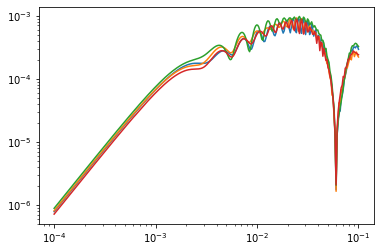

In [131]:
plt.loglog(ORF_AA_TL_f[:,0],ORF_AA_TL_f[:,1])
plt.loglog(ORF_AE_TL_f[:,0],ORF_AE_TL_f[:,1])
plt.loglog(ORF_EA_TL_f[:,0],ORF_EA_TL_f[:,1])
plt.loglog(ORF_EE_TL_f[:,0],ORF_EE_TL_f[:,1])

In [132]:
ORF_AE_TL_TOT = np.sqrt(ORF_AA_TL_f[:,1]**2+ORF_AE_TL_f[:,1]**2+ORF_EA_TL_f[:,1]**2+ORF_EE_TL_f[:,1]**2)

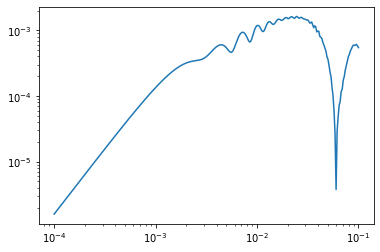

In [133]:
plt.loglog(ORF_AA_TL_f[:,0],ORF_AE_TL_TOT)

In [70]:
ORF_AE_TL_TOT_f = np.array(zip(ORF_AA_TL_f[:,0],ORF_AE_TL_TOT))

In [71]:
np.savetxt('ORF_AE_TL_all.txt',ORF_AE_TL_TOT_f)